# Importing Libraries

In [2]:
#Import the required libraries

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer, IndexToString
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors
from pyspark import SparkContext

In [3]:
#Creating our spark session

spark = SparkSession \
.builder \
.appName("attrition example") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()

# Reading the data from the csv file

In [4]:
att_df = spark.read.load('attrition-db.csv',format="csv",inferschema=True, header=True)

In [5]:
#Schema of the data that we are using

att_df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EmployeeNumber: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- OverTime: string 

# Indexing the features using StringIndexer

In [7]:
indexer = StringIndexer(inputCol="Attrition", outputCol="indAttrition")
indexed_att_data = indexer.fit(att_df).transform(att_df)

In [8]:
indexer = StringIndexer(inputCol="BusinessTravel", outputCol="indBusinessTravel")
indexed_att_data = indexer.fit(indexed_att_data).transform(indexed_att_data)

indexer = StringIndexer(inputCol="Department", outputCol="indDepartment")
indexed_att_data = indexer.fit(indexed_att_data).transform(indexed_att_data)

indexer = StringIndexer(inputCol="EducationField", outputCol="indEducationField")
indexed_att_data = indexer.fit(indexed_att_data).transform(indexed_att_data)

indexer = StringIndexer(inputCol="Gender", outputCol="indGender")
indexed_att_data = indexer.fit(indexed_att_data).transform(indexed_att_data)

indexer = StringIndexer(inputCol="JobRole", outputCol="indJobRole")
indexed_att_data = indexer.fit(indexed_att_data).transform(indexed_att_data)

indexer = StringIndexer(inputCol="MaritalStatus", outputCol="indMaritalStatus")
indexed_att_data = indexer.fit(indexed_att_data).transform(indexed_att_data)

indexer = StringIndexer(inputCol="Over18", outputCol="indOver18")
indexed_att_data = indexer.fit(indexed_att_data).transform(indexed_att_data)

indexer = StringIndexer(inputCol="OverTime", outputCol="indOverTime")
indexed_att_data = indexer.fit(indexed_att_data).transform(indexed_att_data)

# VectorAssembler

In [12]:
#the features are assembled in a vector called "features"

vectorAss = VectorAssembler(inputCols=["Age",
                                       "indBusinessTravel",
                                       "DailyRate",
                                       "indDepartment",
                                      "DistanceFromHome","Education","indEducationField",
                                      "EmployeeCount","EmployeeNumber","EnvironmentSatisfaction",
                                      "indGender","HourlyRate","JobInvolvement","JobLevel","indJobRole",
                                      "JobSatisfaction","indMaritalStatus","MonthlyIncome","MonthlyRate",
                                      "NumCompaniesWorked","indOver18","indOverTime","PercentSalaryHike",
                                      "PerformanceRating","RelationshipSatisfaction","StandardHours",
                                      "StockOptionLevel","TotalWorkingYears","TotalWorkingYears",
                                      "TrainingTimesLastYear","WorkLifeBalance","YearsAtCompany",
                                      "YearsAtCompany","YearsInCurrentRole","YearsSinceLastPromotion",
                                      "YearsWithCurrManager"]
                            ,outputCol="features")

data = vectorAss.transform(indexed_att_data)

# FeatureIndexer

In [13]:
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Splitting the data for training and testing

In [14]:
#The data is split into trainData = 70% and testData = 30%

(trainData, testData) = data.randomSplit([0.7,0.3])

# Applying RandomForestClassifier on the data

In [15]:
rf = RandomForestClassifier(labelCol="indexedAttrition", featuresCol="indexedFeatures", numTrees=10)

# Converting the predicted value to a string

In [16]:
labelIndexer = StringIndexer(inputCol="Attrition", outputCol="indexedAttrition").fit(indexed_att_data)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Pipeling the stages

In [17]:
#Chain indexers and forest in a Pipeline

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Training the trainData

In [18]:
model = pipeline.fit(trainData)

# Testing the testData

In [19]:
predictions = model.transform(data)

In [20]:
indexer_new = StringIndexer(inputCol="predictedLabel", outputCol="indexedPredictedLabel")
ind_pred = indexer_new.fit(predictions).transform(predictions)

# Evaluating our model

In [21]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedAttrition", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g" % (accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

Test Error = 0.131973
Accuracy = 0.868027
RandomForestClassificationModel (uid=RandomForestClassifier_4240b37b2adb7fd783dd) with 10 trees


# Confusion Matrix

In [22]:
tp = ind_pred[(ind_pred.indAttrition == 1) & (ind_pred.indexedPredictedLabel == 1)].count()
tn = ind_pred[(ind_pred.indAttrition == 0) & (ind_pred.indexedPredictedLabel == 0)].count()
fp = ind_pred[(ind_pred.indAttrition == 0) & (ind_pred.indexedPredictedLabel == 1)].count()
fn = ind_pred[(ind_pred.indAttrition == 1) & (ind_pred.indexedPredictedLabel == 0)].count()
print ("True Positives:", tp)
print ("True Negatives:", tn)
print ("False Positives:", fp)
print ("False Negatives:", fn)
print ("Total", data.count())

True Positives: 45
True Negatives: 1231
False Positives: 2
False Negatives: 192
Total 1470


# Finding the correlation between the variables
## Using the Pearson coefficient for coorelation

In [23]:
from scipy.stats.stats import pearsonr

In [33]:
#importing the libraries needed for data visualisation

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

%matplotlib inline
rcParams['figure.figsize'] = 20, 20
plt.style.use('seaborn-whitegrid')

In [34]:
import pandas as pd

In [35]:
#converting the spark df into pandas df

pd_data = ind_pred.toPandas()

In [36]:
#converting the pandas df into a 2D array (numpy)
np_data = pd_data.values

In [37]:
sns.set()

In [38]:
#dropping the columns with dataType = string to plot the heatmap

ind_pred = ind_pred.drop('BusinessTravel')
ind_pred = ind_pred.drop('OverTime')
ind_pred = ind_pred.drop('Over18')
ind_pred = ind_pred.drop('MaritalStatus')
ind_pred = ind_pred.drop('JobRole')
ind_pred = ind_pred.drop('Gender')
ind_pred = ind_pred.drop('EducationField')
ind_pred = ind_pred.drop('Department')

In [39]:
ind_pred = ind_pred.drop('Attrition')

In [40]:
#Finding the correlation matrix

corr = pd_data.corr()
corr

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,indDepartment,indEducationField,indGender,indJobRole,indMaritalStatus,indOver18,indOverTime,indexedAttrition,prediction,indexedPredictedLabel
Age,1.000000,0.010661,-0.001686,0.208034,NaN,-0.010145,0.010146,0.024287,0.029820,0.509604,...,-0.007652,-0.030912,0.036311,0.159715,-0.035466,NaN,0.028062,-0.159205,-0.192833,-0.192833
DailyRate,0.010661,1.000000,-0.004985,-0.016806,NaN,-0.050990,0.018355,0.023381,0.046135,0.002966,...,-0.021959,-0.023428,0.011716,-0.002507,-0.005724,NaN,0.009135,-0.056652,-0.039100,-0.039100
DistanceFromHome,-0.001686,-0.004985,1.000000,0.021042,NaN,0.032916,-0.016075,0.031131,0.008783,0.005303,...,0.002196,0.006907,0.001851,-0.043595,-0.021916,NaN,0.025514,0.077924,0.035762,0.035762
Education,0.208034,-0.016806,0.021042,1.000000,NaN,0.042070,-0.027128,0.016775,0.042438,0.101589,...,0.019636,0.031898,0.016547,-0.019223,-0.000107,NaN,-0.020322,-0.031373,-0.097848,-0.097848
EmployeeCount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EmployeeNumber,-0.010145,-0.050990,0.032916,0.042070,NaN,1.000000,0.017621,0.035179,-0.006888,-0.018519,...,0.057663,0.019673,-0.022556,0.015496,-0.047224,NaN,-0.024037,-0.010577,-0.006063,-0.006063
EnvironmentSatisfaction,0.010146,0.018355,-0.016075,-0.027128,NaN,0.017621,1.000000,-0.049857,-0.008278,0.001212,...,-0.026110,0.053399,-0.000508,-0.010129,0.022628,NaN,0.070132,-0.103369,0.000272,0.000272
HourlyRate,0.024287,0.023381,0.031131,0.016775,NaN,0.035179,-0.049857,1.000000,0.042861,-0.027853,...,-0.021528,-0.045268,0.000478,-0.020728,-0.026198,NaN,-0.007782,-0.006846,0.010297,0.010297
JobInvolvement,0.029820,0.046135,0.008783,0.042438,NaN,-0.006888,-0.008278,0.042861,1.000000,-0.012630,...,-0.017693,-0.013218,-0.017960,-0.006766,-0.009005,NaN,-0.003507,-0.130016,-0.050592,-0.050592
JobLevel,0.509604,0.002966,0.005303,0.101589,NaN,-0.018519,0.001212,-0.027853,-0.012630,1.000000,...,0.088018,-0.003307,0.039403,0.313588,-0.012346,NaN,0.000544,-0.169105,-0.167750,-0.167750


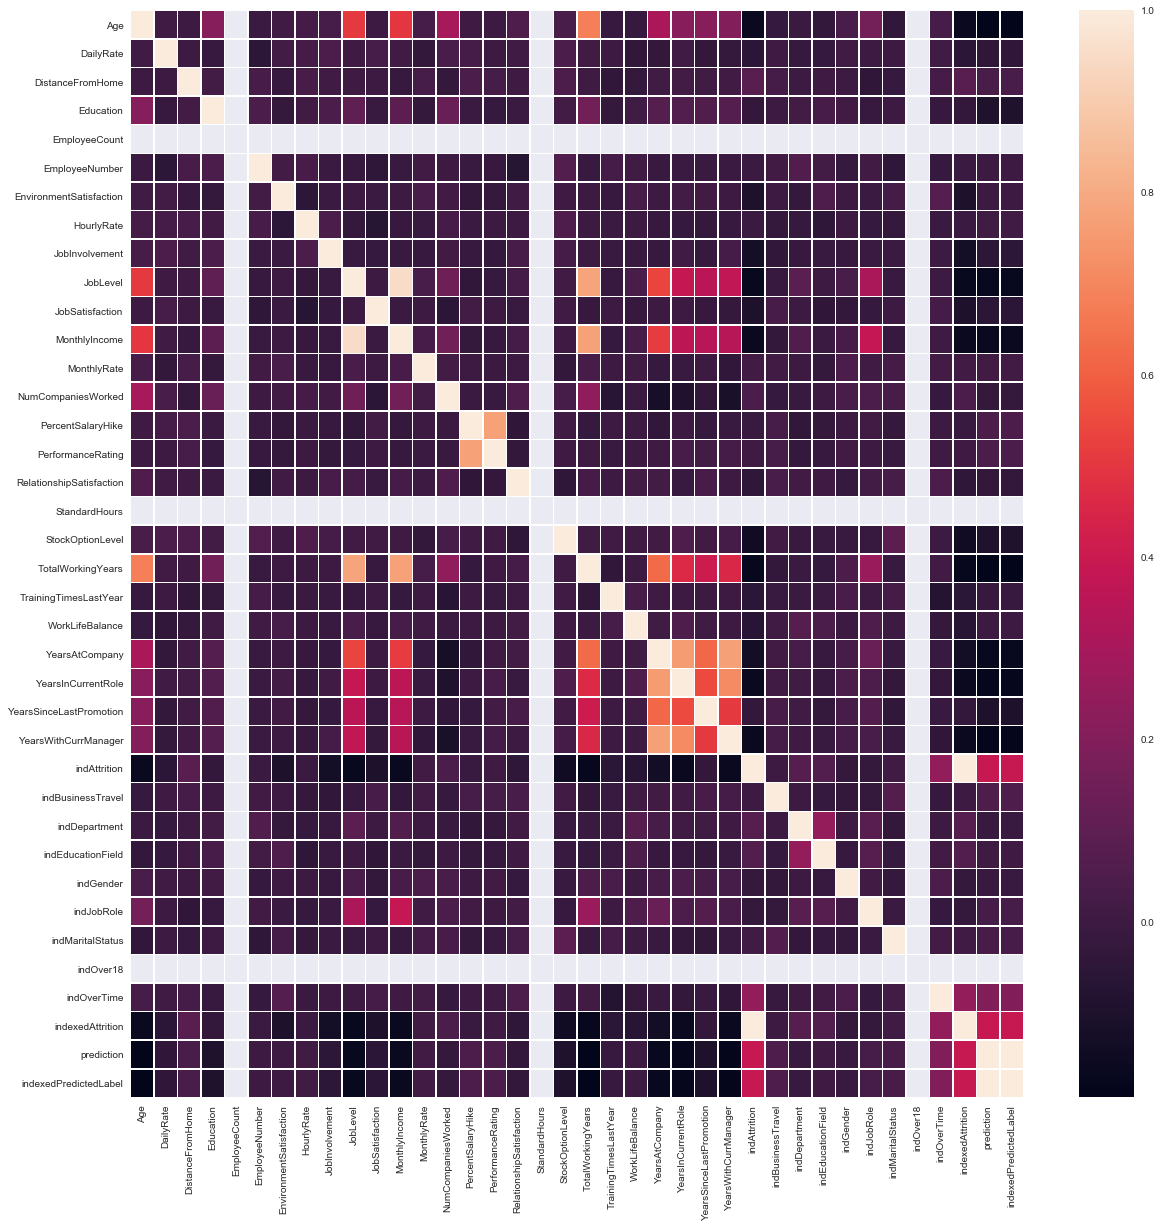

In [42]:
#plotting the heat-map

sns.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values,linewidths=0.5)

# Scatter Plots for understanding the correlations between the features

Text(0,0.5,'YearsAtCompany')

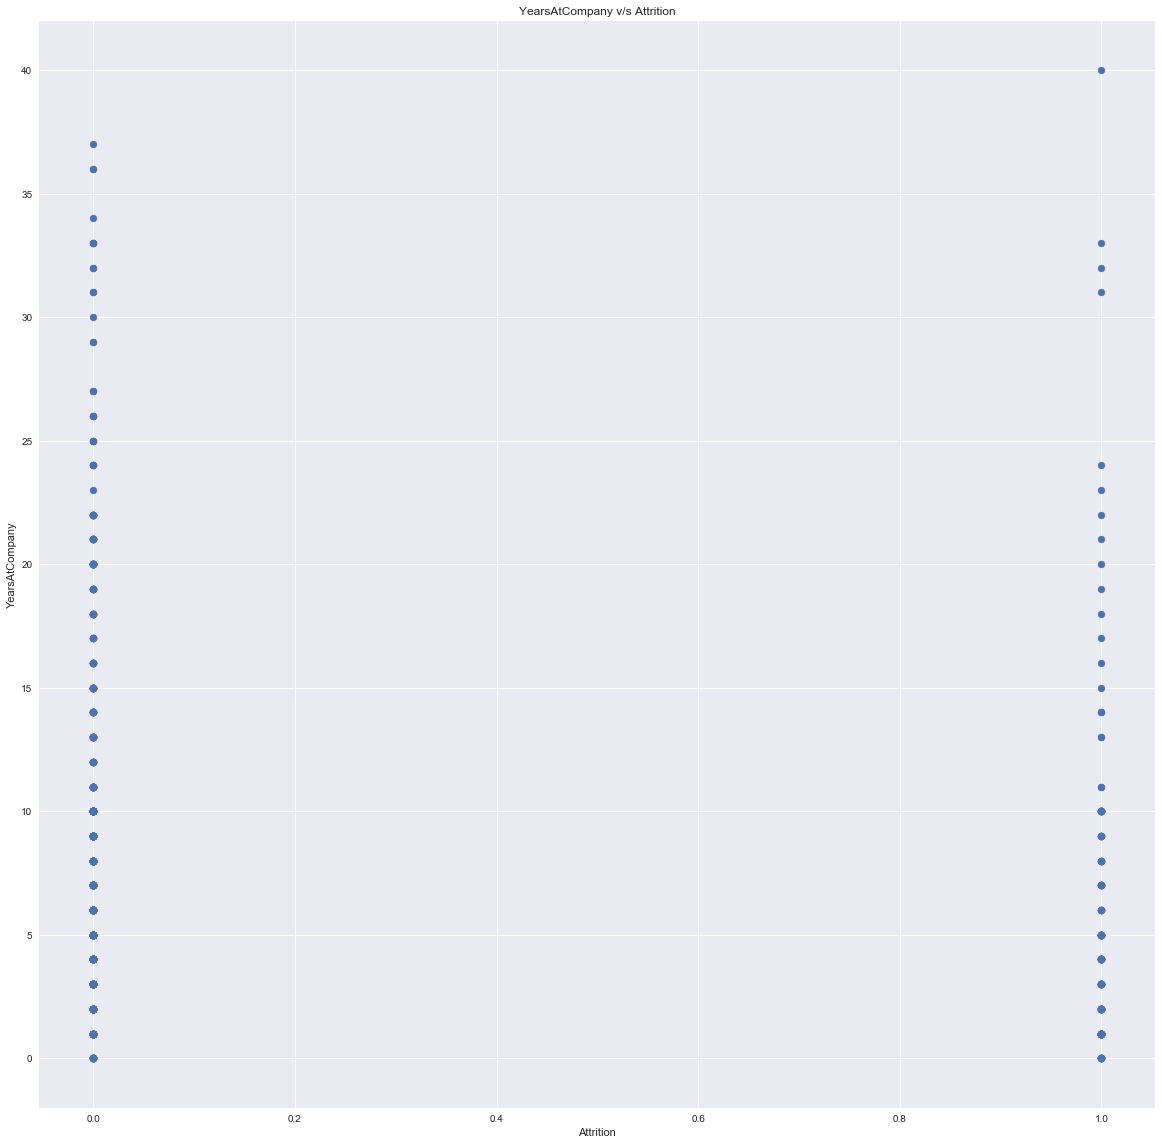

In [64]:
x = pd_data['indexedAttrition']
y = pd_data['YearsAtCompany']
 
# Create scatter plot
plt.scatter(x, y)
 
# Add title and axis names
plt.title('YearsAtCompany v/s Attrition')
plt.xlabel('Attrition')
plt.ylabel('YearsAtCompany')

Text(0,0.5,'MonthlyIncome')

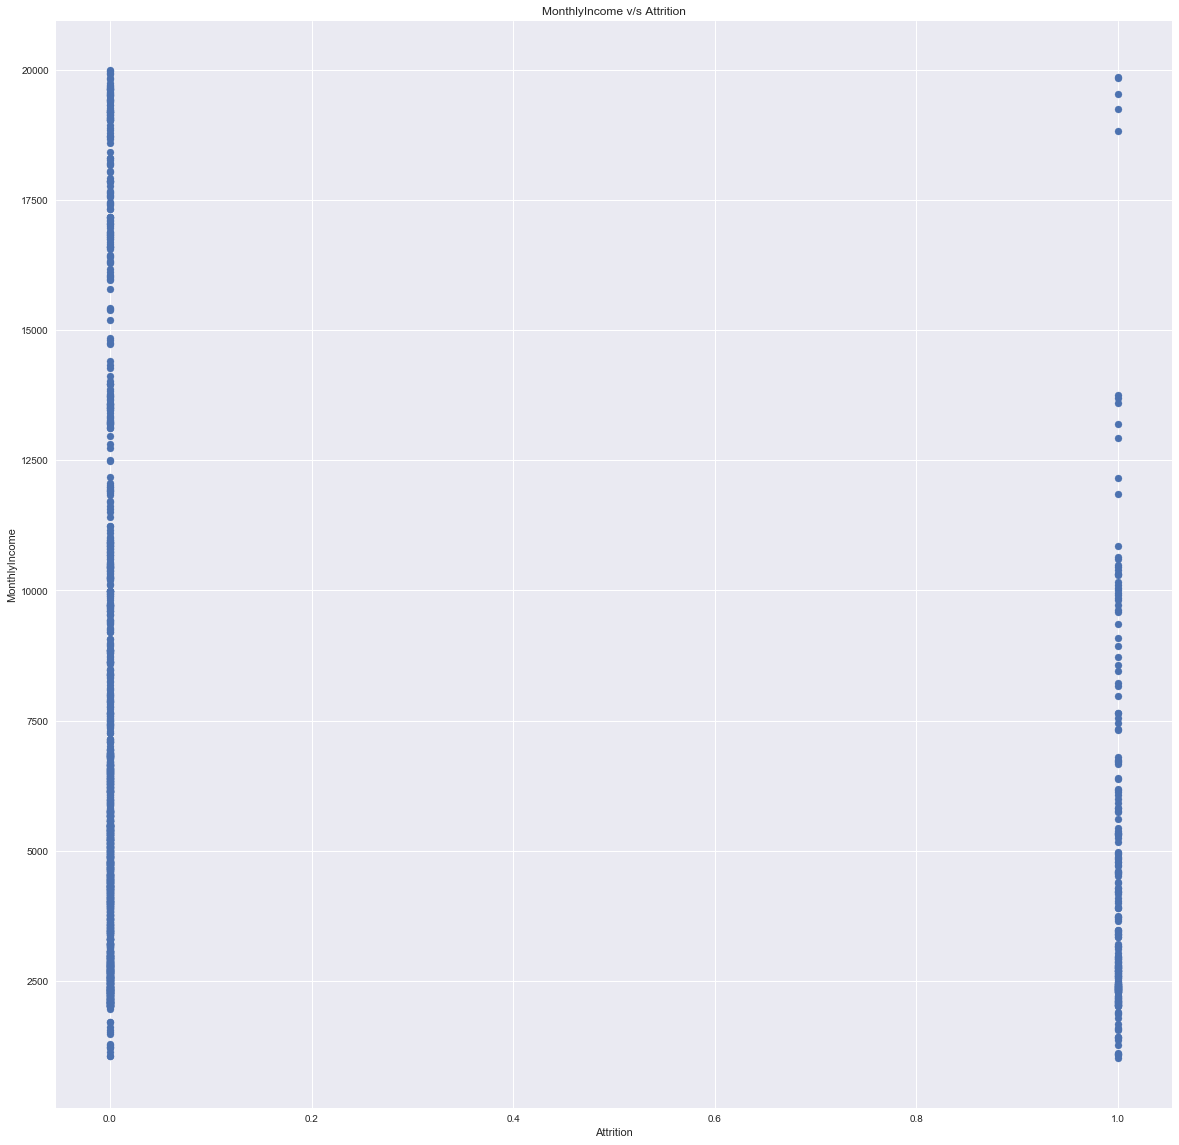

In [65]:
x = pd_data['indexedAttrition']
y = pd_data['MonthlyIncome']
 
# Create scatter plot
plt.scatter(x, y)
 
# Add title and axis names
plt.title('MonthlyIncome v/s Attrition')
plt.xlabel('Attrition')
plt.ylabel('MonthlyIncome')

Text(0,0.5,'Age')

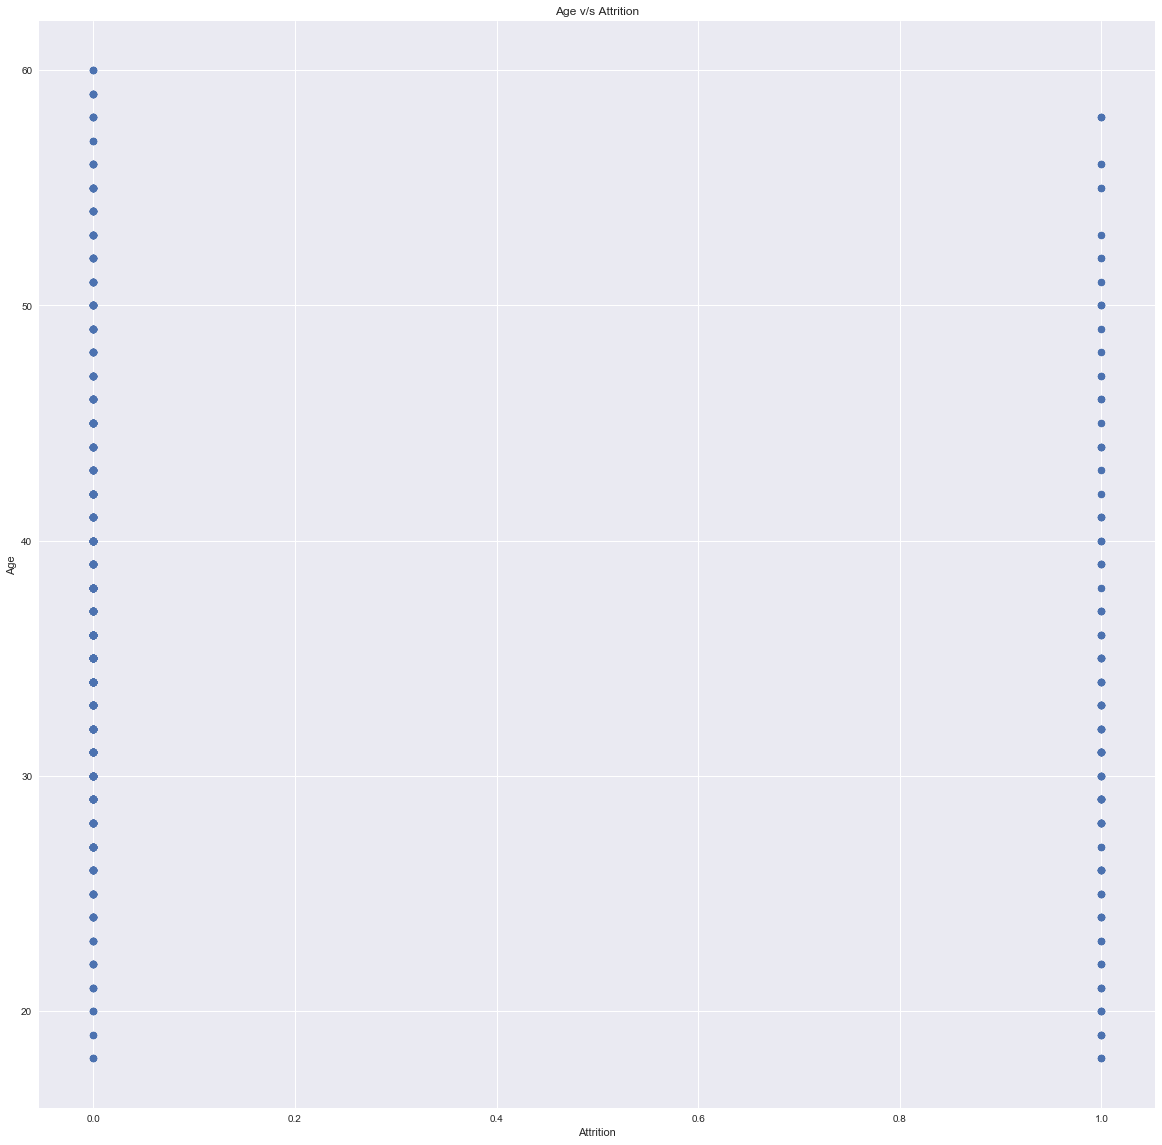

In [67]:
x = pd_data['indexedAttrition']
y = pd_data['Age']
 
# Create scatter plot
plt.scatter(x, y)
 
# Add title and axis names
plt.title('Age v/s Attrition')
plt.xlabel('Attrition')
plt.ylabel('Age')